# Exploratory Data Analysis Into How Iowa, The Third Largest Farming State,Voted

## Intro

In 2021, the top 3 states with the largest number of farms were Texas, Missouri, and Iowa. In 2020, all 3 states voted "red". We wanted to know if the majority of the population/counties in Iowa voted red, or if one party just barely managed to edge out. We want to be able to know if certain counties with more or less farmland vote more red or blue. According to many polls, farmers have tended to lean towards the Reublican party in recent history, so we want to see if there is enough of a presence of farmers in Iowa such that the state is majority red, or if the majority of people there vote for another party.

## EDA

We start by importing necessary libraries and reading in the data correctly from our Google Cloud Buckets

In [332]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import collect_list
from pyspark.sql.types import StructField, StructType, StringType, LongType
import pandas as pd

In [333]:
Iowa = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://final_project_pc/VM2Uniform--IA--2021-03-04.tab")


The only columns we are currently interested in is how each county voted and what the number of votes were. So we subset the necessary columns and drop all others

In [337]:
Iowa = Iowa[['County','Parties_Description']]
Iowa = Iowa.toPandas()

We will now show a graph of the number of counts each major party received. A party is considered major if it received at least one vote in each county. It is a bit hard to tell who exactly has the most votes, so the table below sumarizes which party had the most votes.

<AxesSubplot:xlabel='Party'>

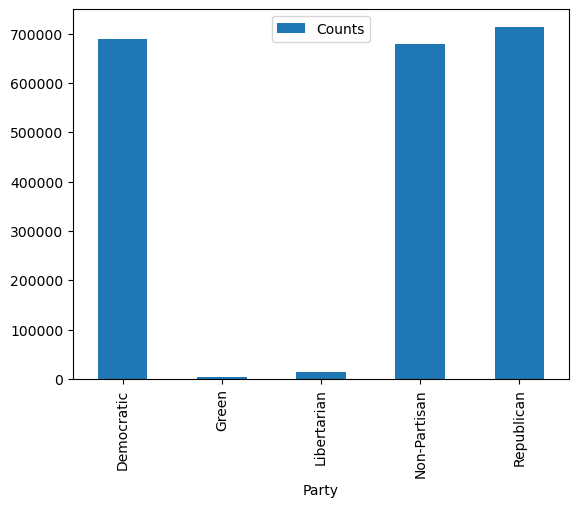

In [338]:
Iowa_PC = Iowa.groupby('Parties_Description').count().reset_index()
Iowa_PC.columns = ['Party', 'Counts']
Iowa_PC.plot(x = 'Party', y = 'Counts', kind = 'bar')

In [360]:
Iowa['Parties_Description'].value_counts().to_frame()

,Parties_Description
Republican,713219
Democratic,689374
Non-Partisan,679490
Libertarian,14416
Green,3859


As we can see, the Republican party got the most votes, but it just barely had more than both the Democratic and Non-Partisan parties

We will now see how each county voted in Iowa. Looking at our initial table, it is a bit hard to tell how each county voted.

In [362]:
Iowa_TCC = Iowa.value_counts().reset_index()
Iowa_TCC.columns = ['County', 'Parties_Description', 'Counts']
Iowa_TCC = Iowa_TCC.sort_values('County')
Iowa_TCC = Iowa_TCC.set_index('County')
Iowa_TCC

,Parties_Description,Counts
County,,
ADAIR,Non-Partisan,1914
ADAIR,Libertarian,23
ADAIR,Green,6
ADAIR,Democratic,1034
ADAIR,Republican,2251
...,...,...
WRIGHT,Libertarian,27
WRIGHT,Green,9
WRIGHT,Democratic,1820


Because the table is hard to read, we will transform the data. The code below makes each county had the respective parties vote count in each column. They were abbreviated as the starting letter(s) of the party and then 'count' after.

In [368]:
Iowa_CC = pd.DataFrame()

Iowa_CC['Rcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Republican']['Counts']
Iowa_CC['Dcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Democratic']['Counts']
Iowa_CC['NPcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Non-Partisan']['Counts']
Iowa_CC['Lcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Libertarian']['Counts']
Iowa_CC['Gcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Green']['Counts']

Iowa_CC

,Rcount,Dcount,NPcount,Lcount,Gcount
County,,,,,
ADAIR,2251,1034,1914,23,6
ADAMS,1137,550,968,11,2
ALLAMAKEE,4216,2216,2795,38,10
APPANOOSE,3434,2103,2712,44,11
AUDUBON,1978,991,1133,13,3
...,...,...,...,...,...
WINNEBAGO,2990,1739,2692,45,7
WINNESHIEK,4725,4887,4935,53,23
WOODBURY,22646,18781,18249,383,125


Looking at a barplot of how each county voted and how each party did in each county, it is very hard to gather any information from it

<AxesSubplot:xlabel='County'>

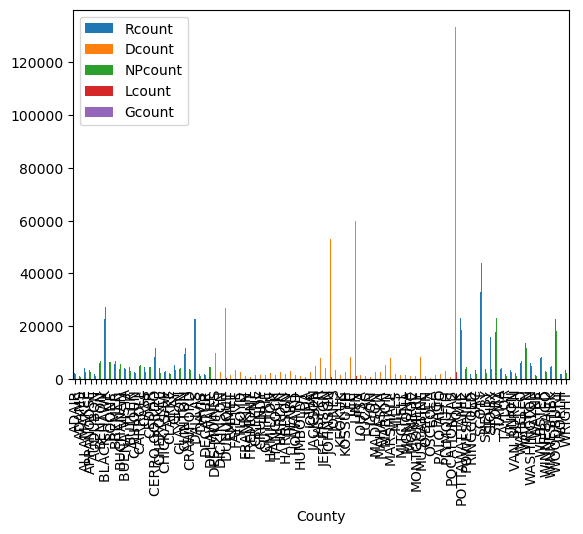

In [370]:
Iowa_CC = Iowa_CC.reset_index()
Iowa_CC.plot(x = 'County', y = ['Rcount','Dcount','NPcount','Lcount','Gcount'], kind = 'bar')

This is because there were so many counties that it is hard to fit it on a graph. In fact, there are 99 counties. Instead we can look at individual graphs. We will take a look at just the Republican and Democratic parties as those were the final contenders in the 2020 election and see if there is a clearly winner in votes

<AxesSubplot:xlabel='County'>

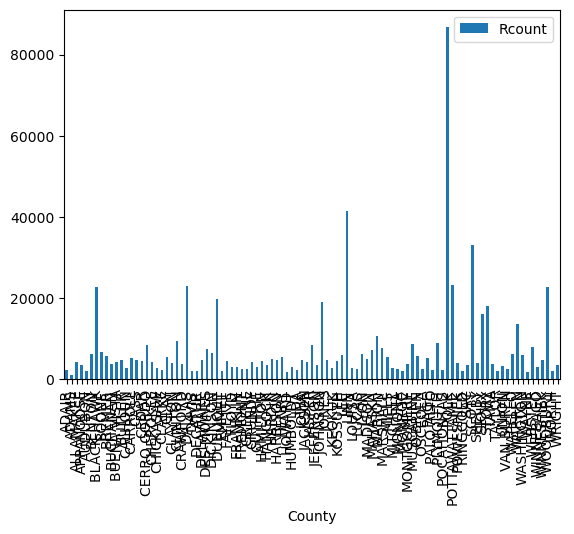

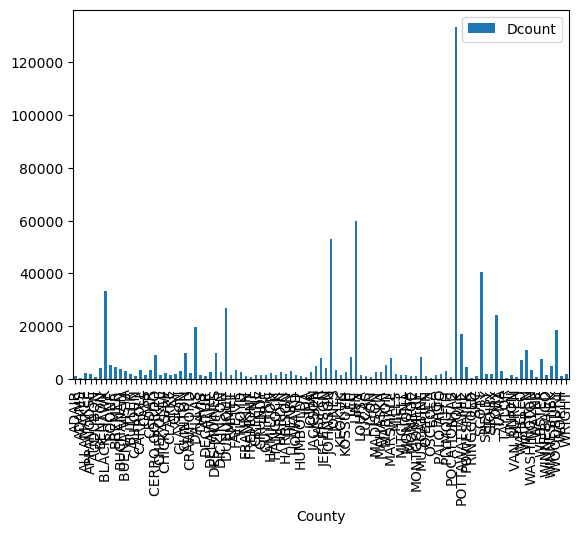

In [377]:
Iowa_R = Iowa_CC[['County','Rcount']]
Iowa_R.plot(x = 'County', y = 'Rcount', kind = 'bar')

Iowa_D = Iowa_CC[['County','Dcount']]
Iowa_D.plot(x = 'County', y = 'Dcount', kind = 'bar')

As we can see, it is still hard to capture all 99 counties in a single graph, but from the general trend of the barplots, they appear similar in shape and count. This suggests that many counties are not voting as a majority for either the Democratic or Republican party. Rather they are split about 50/50. As stated before Iowa ended up voting as a red state, so it seems that altough close, the Republican party managed to edge out a bit more votes to win

For further EDA, we shall take a look at how the other parties did against each other. 

<AxesSubplot:xlabel='County'>

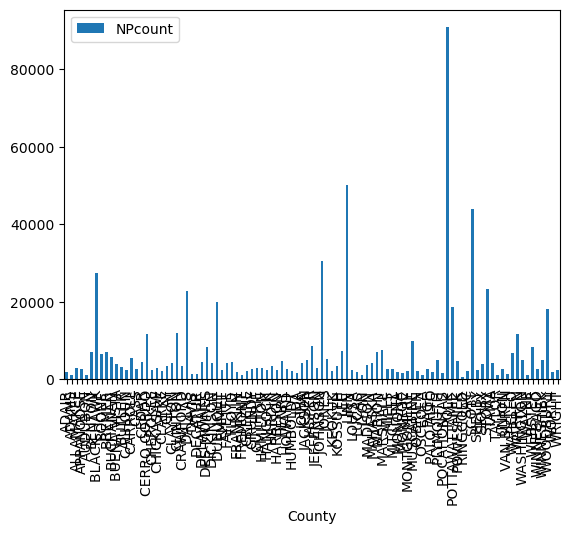

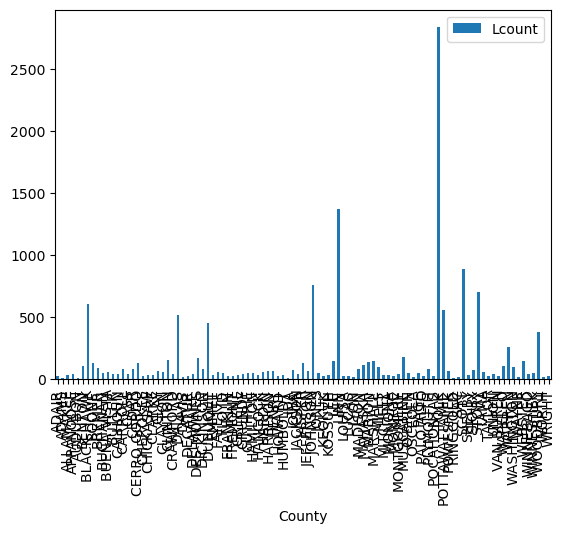

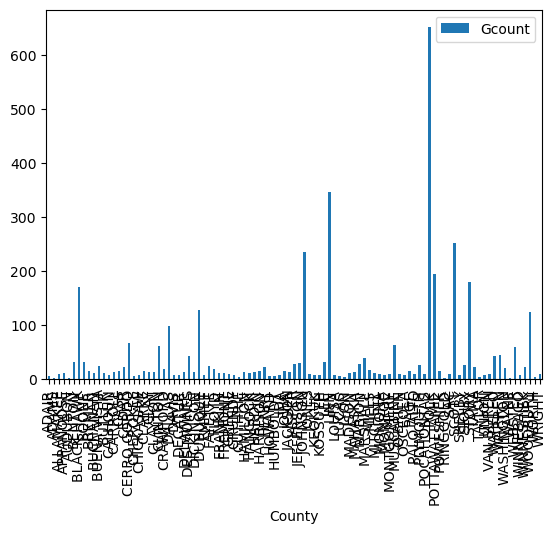

In [378]:
Iowa_NP = Iowa_CC[['County','NPcount']]
Iowa_NP.plot(x = 'County', y = 'NPcount', kind = 'bar')

Iowa_L = Iowa_CC[['County','Lcount']]
Iowa_L.plot(x = 'County', y = 'Lcount', kind = 'bar')

Iowa_G = Iowa_CC[['County','Gcount']]
Iowa_G.plot(x = 'County', y = 'Gcount', kind = 'bar')

Looking at all three of these other parties, we can see that just like the Democratic and Republican party, they have a similar trend in shape, but not numbers. The Green Party, bottom graph, had such small count numbers on the y-axis. In fact, they received less than 4,000 votes. The Libertarian party also received a small proportion of total votes. It had less than 15,000 votes. The Non-Partisan party, however, received almost as many votes as the Democratic party. This clearly shows that each county did not vote for a majority at all. It was a close 3 way tie between the Republican, Democratic, and Non-Partisan party. It seems that Iowa just barely managed to vote red. 

## Conclusion

Our EDA into Iowa's voting habits shows us that although Iowa voted red in the 2020 election, there is no majority party that the people voted for. Rather, the number of votes between the Democratic, Republican, and Non-Partisan party was very close. Each party differed by only a couple thousan votes. The smaller Libertarian and Green party had around 20,000 votes combined which could have swing the vote for a party. Those 20,000 votes could easily guarantee a party having the majority vote. It will be interesting to see what Texas's and Missouri's voting habits will look like. It is possible that the smaller parties don't have as much of a presence and so there is a clear winner in votes. It could also be similar where the vote difference between the largest parties is possibly even only a couple hundred. In the end we can conclude that just because Iowa is a farming state does not mean it is a majority Republican state.